In [1]:
import funclib as flib
import matplotlib as mplt

Read data

In [2]:
directory = "../.."
data = {}

for group in ["Mammals", "Birds"]:
    model_params, xy_data = flib.read_model_xy(group, "./../../scripts/pgls_res/Me5")
    data[group] = {"params":model_params,
                   "xy":xy_data}

complete_data = pd.read_csv("{}/data/Table_S2.csv".format(directory))
sp2common = flib.df2dict(complete_data, "Species", "Common_name")
gen_times = flib.df2dict(complete_data, "Species", "Generation_time_y")
yearly_rates = flib.df2dict(complete_data, "Species", "MutPerYearUCSC")
yearly_rates = {k:v/1e6 for k,v in yearly_rates.items()}

palette = flib.df2dict(pd.read_csv("{}/data/plot_colors.tsv".format(directory),sep="\t"), "Order", "Color")

Figure 4

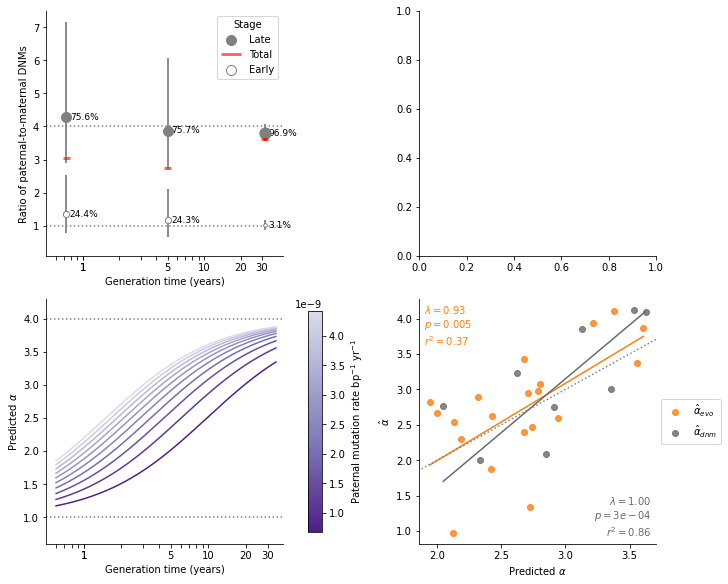

In [8]:
f,axs0 = plt.subplots(2, 2, figsize=[10,8],constrained_layout=True)
axs = axs0.reshape(-1)

##########################
##### Common styling #####
##########################
alpha_y_range = [0.6, 4.3]
g_x_range = [np.log10(0.5), np.log10(40)]
original_Gs = list(np.linspace(0.6,1,5)) + list(range(1,11)) + [20,30]
xlabels = ["" if g not in [1,5,10,20,30] else g for g in original_Gs]
log10_Gs = np.log10(original_Gs)

##########################
######## Panel A #########
##########################
ax = axs[0]

####### Read data ########
dnm_stages = pd.read_csv("../../data/dnm_stages.csv")
total_paternal = dnm_stages.groupby("Species").apply(lambda x: x.Paternal.sum()).to_dict()
total_maternal = dnm_stages.groupby("Species").apply(lambda x: x.Maternal.sum()).to_dict()
species_ages = dnm_stages.set_index("Species")["Parental_age"].to_dict()

##### Add All (Total) ####
frac_ee = {}

for sp,df in dnm_stages.groupby("Species"):
    m_dnms, p_dnms = flib.extraploate_parental_dnms(df)
    total_alpha = p_dnms/m_dnms
    all_df = pd.DataFrame([sp, p_dnms, m_dnms, p_dnms+m_dnms, "All", species_ages[sp]]).transpose()    
    all_df.columns = dnm_stages.columns
    dnm_stages = pd.concat([dnm_stages,all_df])
    ee = flib.fraction_ee(df)
    frac_ee[sp] = ee   
    
dnm_stages = dnm_stages.reset_index(drop=True)
dnm_stages = flib.add_binomial_CIs(dnm_stages)
dnm_stages["Parental_age_log"] = np.log10(list(dnm_stages.Parental_age))
dnm_stages = dnm_stages.replace("Early_embryonic","Early").replace("PostPGCS","Late")

###### Plot scatter ######
margin = 0.03
for sp,df in dnm_stages.groupby("Species"):
    
    all_alpha = df[df.Stage=="All"]["point"].values[0]
    ee_dnm = df[df.Stage=="Early"]["point"].values[0]
    postpgcs_dnm = df[df.Stage=="Late"]["point"].values[0]
    g = df[df.Stage=="Early"]["Parental_age_log"].values[0]
    
    ### EE ###
    ax.scatter(g, ee_dnm, c="white", edgecolor="gray", zorder=10, s=int(frac_ee[sp]*120)+10) 
    ax.annotate("{:.1f}%".format(frac_ee[sp]*100), xy=(g+margin, ee_dnm), va="center", fontsize=9)
    
    ### Post-PGCS ###
    ax.scatter(g, postpgcs_dnm, c="gray", edgecolor="gray", zorder=10, s=int((1-frac_ee[sp])*120)+10)
    ax.annotate("{:.1f}%".format((1-frac_ee[sp])*100), xy=(g+margin, postpgcs_dnm), va="center", fontsize=9)
    
    ### All (Total) ###
    xmin = df.Parental_age_log.values[0] - margin
    xmax = df.Parental_age_log.values[0] + margin
    ax.hlines(y=all_alpha, xmin=xmin, xmax=xmax,
              color="red", zorder=10, linewidth=3, alpha=0.6)
    
    ### Legend ###
    if sp=="Homo_sapiens":
        ax.scatter(1e3,1e3,s=100,c="gray", edgecolor="gray", label="Late")
        ax.hlines(y=all_alpha, xmin=xmin+(margin/2), xmax=xmax-(margin/2),
                  color="red", zorder=10, linewidth=3, alpha=0.6, label="Total")
        ax.scatter(1e3,1e3,s=100,c="white", edgecolor="gray", label="Early")
           
###### Plot CIs ########
for i,r in dnm_stages[dnm_stages.Stage!="All"].iterrows():
    ax.vlines(x = r.Parental_age_log, ymin = r.low, ymax = r.high,color="dimgray")

####### Styling ########
ax.legend(title="Stage")
ax.axhline(y=4, color="gray",linestyle="dotted",label="")
ax.axhline(y=1, color="gray",linestyle="dotted",label="")

######## Axes #########
ax.set_xlim([g_x_range[0], g_x_range[1]+0.05])
ax.set_ylim([0.085, 7.496])
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation time (years)")
ax.set_ylabel("Ratio of paternal-to-maternal DNMs")

##########################
######## Panel B #########
##########################
ax=axs[2]

mammal_traits = data["Mammals"]["xy"]

######## Params #########
n_e = 5/3e9
Gs = list(np.linspace(0.6, 1, 1000)) + list(np.linspace(1, 35, 1000))
n_partitions = 10
species = list(yearly_rates.keys())

### Parental age effects ###
mu_ms = []
paternal_effects = {}

for i,sp in enumerate(species):
    mu_f, mu_m = flib.get_parental_age_effects_yrate(yearly_rates[sp], gen_times[sp], gen_times[sp], n_e, 4)
    paternal_effects[sp] = mu_m
    mu_ms.append(mu_m)
    
mu_m_space = np.linspace(min(mu_ms),max(mu_ms),n_partitions)
cmap = plt.get_cmap('Purples_r')
new_cmap = flib.truncate_colormap(cmap, 0.1, 0.75)
norm = mplt.colors.Normalize(vmin=min(mu_ms), vmax=max(mu_ms), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=new_cmap)
curves = [ax.plot(np.log10(Gs), [flib.predict_alpha(mu_m/4, mu_m, g, g, n_e) for g in Gs],c=mapper.to_rgba(mu_m)) for i,mu_m in enumerate(mu_m_space)]
toy_points = ax.scatter([100]*n_partitions, mu_m_space, c=mu_m_space, cmap=new_cmap) 
    
####### Styling ########
ax.axhline(y=4, linestyle="dotted", color="gray")
ax.axhline(y=1, linestyle="dotted", color="gray")
cbar = plt.colorbar(toy_points, ax=ax, shrink=0.9)#axs[1:2],aspect=100,shrink=0.5
cbar.set_label(r"Paternal mutation rate bp$^{-1}$ yr$^{-1}$")

######## Axes #########
ax.set_xlim(g_x_range)
ax.set_ylim(alpha_y_range)
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation time (years)")
ax.set_ylabel(r"Predicted $\alpha$")

##########################
######## Panel C #########
##########################
ax = axs[3]

####### Read data ########
dnm_params, dnm_data = flib.read_model_xy("DNMs", "./../../scripts/pgls_res/Me5/")
exp = "Predicted_alpha_dnms_min2trios30dnms.Alpha_dnm"
dnm_data = dnm_data[dnm_data.experiment==exp]
dnm_params = dnm_params[dnm_params.experiment==exp]
data["DNMs"] = {"params":dnm_params, "xy":dnm_data}

pred_alpha_evo = mammal_traits[mammal_traits.experiment==exp].reset_index(drop=True)
pred_alpha_dnm = dnm_data[dnm_data.experiment==exp].reset_index(drop=True)

######## Scatter #########
group = "Mammals"
color = "C1"
stats = flib.plot_pgls(data, group, "Predicted_alpha_evo.Alpha", "pgls_ml", ax, 
                       color, True, 0.8, True, r"$\hat{\alpha}_{evo}$")
ax.text(s = r"$\lambda={:.2f}$".format(stats["lambda"]) + "\n" + r"$p={:.3f}$".format(stats["pval"]) + "\n" + r"$r^2={:.2f}$".format(stats["r2"]),
        x=0.02, y=0.98, va="top",ha="left", transform=ax.transAxes,color=color)

group = "DNMs"
color = "dimgray"
stats = flib.plot_pgls(data, group, exp, "pgls_ml", ax, 
                       color, True, 0.8, True, r"$\hat{\alpha}_{dnm}$")
ax.text(s = r"$\lambda={:.2f}$".format(stats["lambda"]) + "\n" + r"$p={:.0e}$".format(stats["pval"]) + "\n" + r"$r^2={:.2f}$".format(stats["r2"]),
        x=0.98, y=0.02, va="bottom",ha="right", transform=ax.transAxes,color=color)

flib.identity_line(ax,color="gray", ls="dotted")

####### Styling ########
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel(r"Predicted $\alpha$")
ax.set_ylabel(r"$\hat{\alpha}$")

sns.despine()
#f.savefig("../pdfs/Figure_4.pdf")